In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import helper_functions as hf
import joblib
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from category_encoders import HashingEncoder

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

## Introduction
In this notebook I will do a more detailed EDA on application dataset and use random forest model to see if I can boost the ROC score.

## Application Data

In [2]:
application, application_features, application_label = hf.load_application()

### Correlation

In [3]:
correlations = application.corr()['TARGET'].sort_values()
print('Most Positive Correlations:\n', correlations.tail(15))
print('Most Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 DEF_60_CNT_SOCIAL_CIRCLE       0.031276
DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64
Most Negative Correlations:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645
R

I will use a KDE plot to visulize the 4 features with higest correlation to our target label. 
<br>
The KDE can show how the distribution of the features vaires on target label.

In [40]:
def kde_plot(df, col):
    plt.figure(figsize = (10, 6))
    sns.kdeplot(df.loc[df['TARGET'] == 0, col], label = 'repaid')
    sns.kdeplot(df.loc[df['TARGET'] == 1, col], label = 'defaulted')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.title(f'Distribution of {col}')
    plt.show()

#### EXT_SOURCE

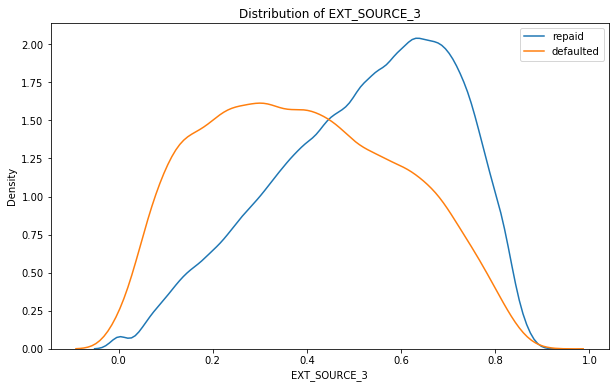

In [41]:
kde_plot(application, 'EXT_SOURCE_3')

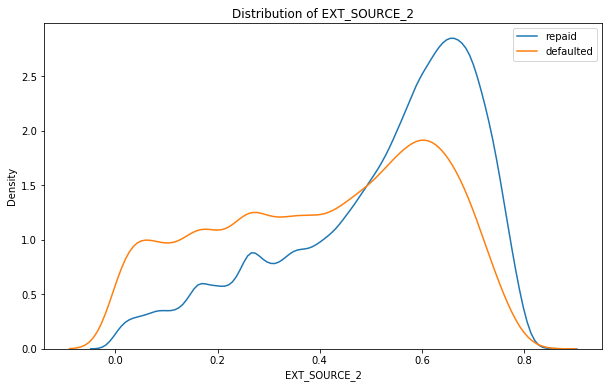

In [42]:
kde_plot(application, 'EXT_SOURCE_2')

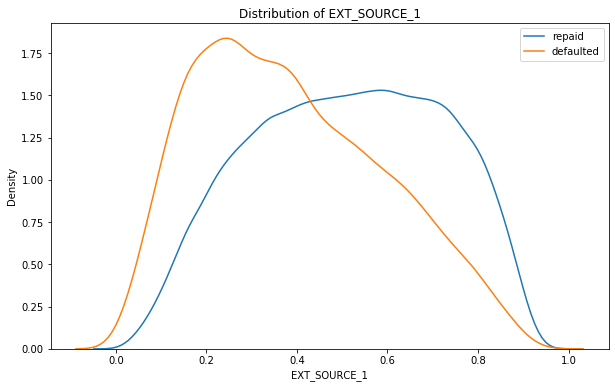

In [43]:
kde_plot(application, 'EXT_SOURCE_1')

#### DAYS_BIRTH

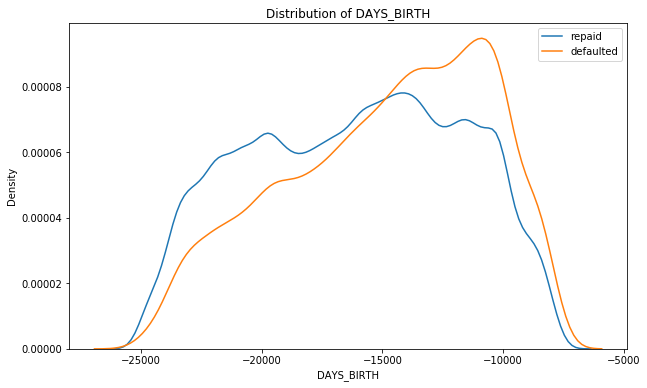

In [44]:
kde_plot(application, 'DAYS_BIRTH')

EXT_SOURCE has most negative correlation with target.
<br>
Let's analyze EXT_SOURCE furthur with target and DAYS_BIRTH

In [9]:
ext_data = application[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,-0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,-0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,-0.205478
DAYS_BIRTH,0.078239,-0.600610,-0.091996,-0.205478,1.000000


EXT_SOURCE_1 has high correlation with age, it may calculated from age.

## Random Forest (Base)

In [10]:
X_train, y_train, X_test, y_test = hf.prepare_training(application_features, application_label)

Spliting Train and Test...
	Training Features shape:  (246009, 121)
	Testing Features shape:  (61502, 121)
One Hot Encoding...
	Training Features shape:  (246009, 229)
	Testing Features shape:  (61502, 228)
Aligning Train and Test...
	Training Features shape:  (246009, 228)
	Testing Features shape:  (61502, 228)

Training Prepared.


In [12]:
rf_base = RandomForestClassifier(max_depth=5, n_estimators=100, class_weight='balanced', random_state=55)
pipe = Pipeline([('impute', SimpleImputer(strategy = 'median')), 
                 ('scaler', MinMaxScaler(feature_range = (0, 1))), 
                 ('rf_base', rf_base)])
with hf.timer('Fitting Base Random Forest Model'):
    pipe.fit(X_train, y_train)

Fitting Base Random Forest Model - done in 27s


Validation ROC: 0.7165015881460894


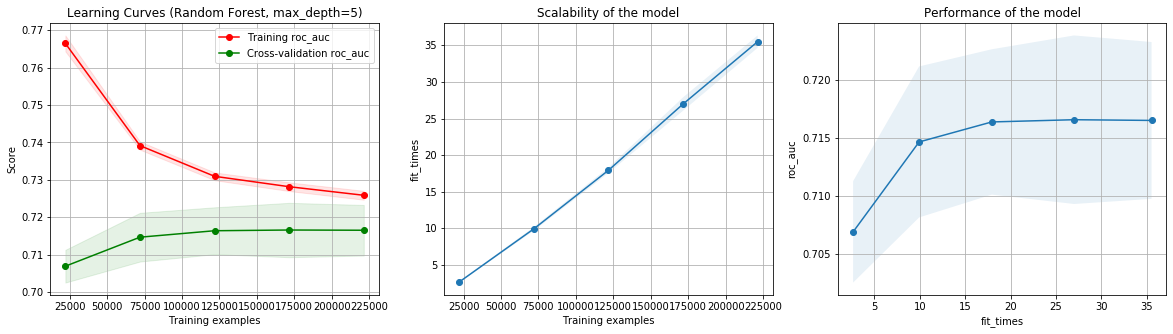

Display Learning Curve - done in 1065s


In [15]:
with hf.timer('Display Learning Curve'):
    title = r"Learning Curves (Random Forest, max_depth=5)"
    hf.display_learning_curve(pipe, X_train, y_train, title)
    plt.show()

It looks like the base random forest model is not better than logistic regression, we will later tune the model to achieve better performance.

## Feature Engineering

We first create a copy of the original features dataframe.

In [49]:
application_new = application.copy()

### Domain Knowledge
Based on my research on morgage risk, I have inclued 6 new features.
>- credit to income ratio: the higher this ratio, the heavier the applicants in debt
>- annuity to income ratio: repaid amount compare to income
>- credit term: amount that the applicants repaid in percentage
>- price to credit: whether applicant is borrowing for goods exceed their repay ability
>- employment length to age ratio: higher means applicants started to work earlier
>- average household income: total income divided by number of family number

In [50]:
def add_features(df):
    df['CREDIT_INCOME_PERCENT'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
    df['ANNUITY_INCOME_PERCENT'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['CREDIT_TERM'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    df['PRICE_CREDIT_PERCENT'] = df['AMT_GOODS_PRICE'] / df['AMT_CREDIT']
    df['DAYS_EMPLOYED_PERCENT'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    return df

In [51]:
application_new = add_features(application_new)

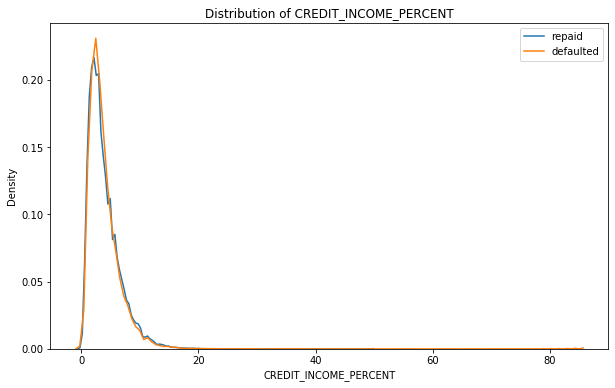

In [45]:
kde_plot(application_new, 'CREDIT_INCOME_PERCENT')

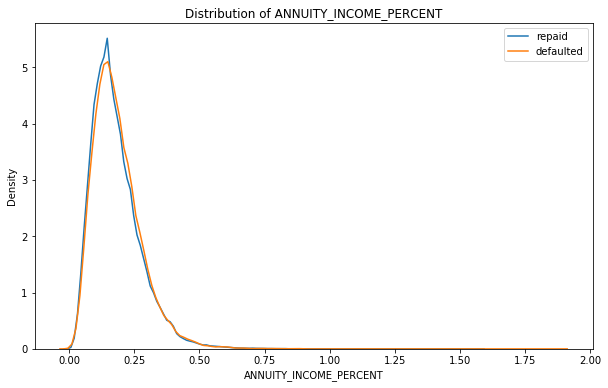

In [46]:
kde_plot(application_new, 'ANNUITY_INCOME_PERCENT')

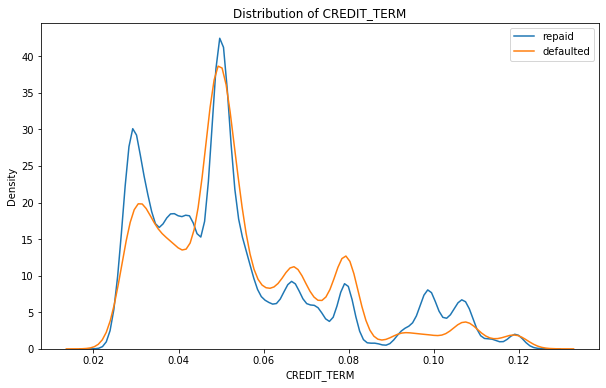

In [48]:
kde_plot(application_new, 'CREDIT_TERM')

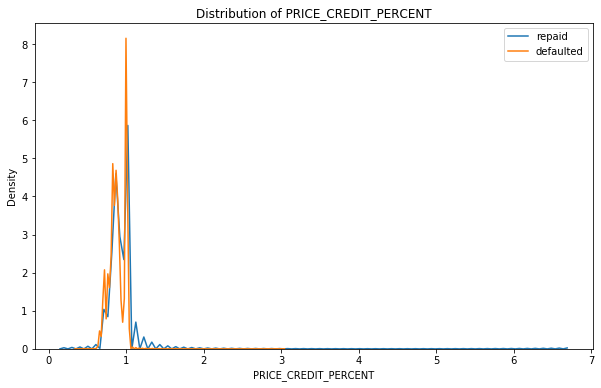

In [52]:
kde_plot(application_new, 'PRICE_CREDIT_PERCENT')

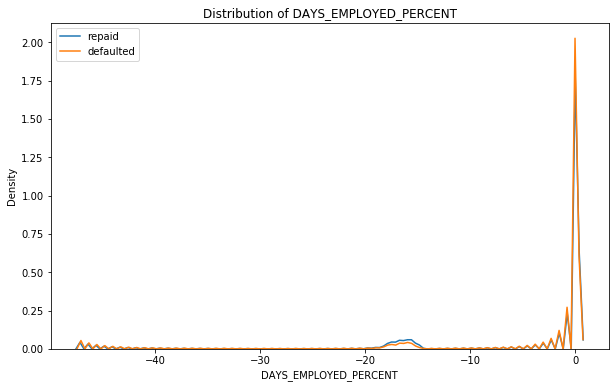

In [53]:
kde_plot(application_new, 'DAYS_EMPLOYED_PERCENT')

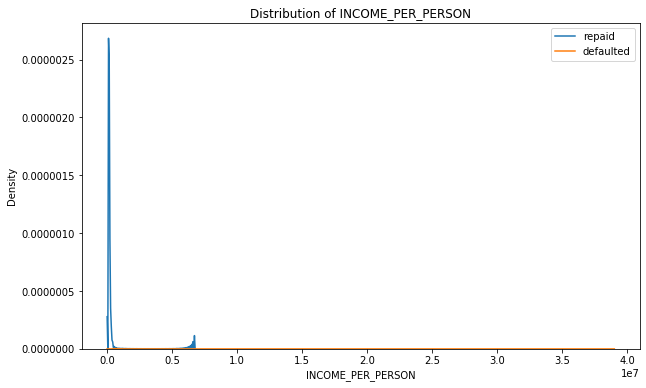

In [47]:
kde_plot(application_new, 'INCOME_PER_PERSON')

In [3]:
application_new, application_features_new, application_label_new = hf.load_application_new()
X_train_new, y_train_new, X_test_new, y_test_new, feat_names = hf.prepare_training(application_features_new, application_label_new)

Spliting Train and Test...
	Training Features shape:  (246009, 127)
	Testing Features shape:  (61502, 127)
One Hot Encoding...
	Training Features shape:  (246009, 235)
	Testing Features shape:  (61502, 234)
Aligning Train and Test...
	Training Features shape:  (246009, 234)
	Testing Features shape:  (61502, 234)

Training Prepared.


After adding new features, let's see how the performance of random forest model and logistic regression change

In [5]:
def fit(model, name, X_train, y_train):
    pipe = Pipeline([('impute', SimpleImputer(strategy = 'median')), 
                     ('scaler', MinMaxScaler(feature_range = (0, 1))), 
                     ('model', model)])
    print('Training data shape: ', X_train.shape)
    pipe.fit(X_train, y_train)
    saved = joblib.dump(pipe, f'Models/{name}.md')
    print(f'Model saved as {saved}')
    return pipe

#### Logistic Regression

In [12]:
lr_base_new = LogisticRegression(C = 0.001, class_weight='balanced')
with hf.timer('Fitting Base Logistic Regression Model with new features'):
    lr_base_new_fitted = fit(lr_base_new, 'Logistic_Regression_New', X_train_new, y_train_new)

Training data shape:  (246009, 234)
Model saved as ['Models/Logistic_Regression_New.md']
Fitting Base Logistic Regression Model with new features - done in 12s


Validation ROC: 0.73987343220779


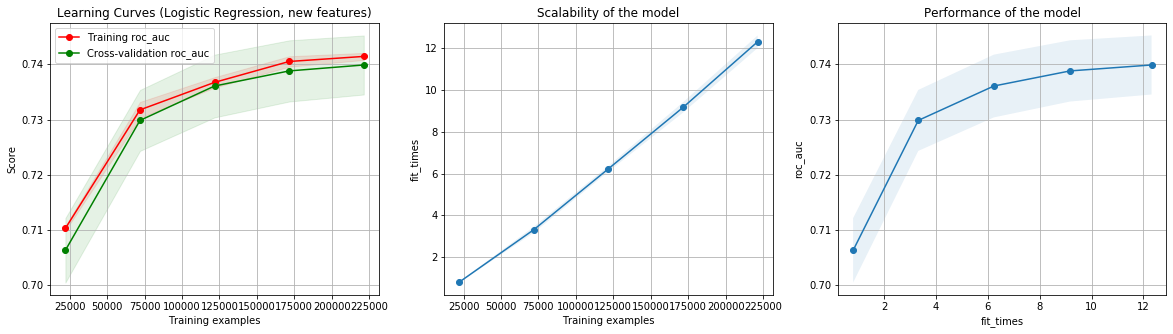

Display Learning Curve - done in 396s


In [7]:
with hf.timer('Display Learning Curve'):
    title = r"Learning Curves (Logistic Regression, new features)"
    hf.display_learning_curve(lr_base_new_fitted, X_train_new, y_train_new, title)
    plt.show()

#### Random Forest

In [11]:
rf_base_new = RandomForestClassifier(max_depth=7, n_estimators=300, class_weight='balanced', random_state=55)
with hf.timer('Fitting Base Random Forest Model with new features'):
    rf_base_new_fitted = fit(rf_base_new, 'Random_Forest_New', X_train_new, y_train_new)

Training data shape:  (246009, 234)
Model saved as ['Models/Random_Forest_New.md']
Fitting Base Random Forest Model with new features - done in 102s


Validation ROC: 0.7294981023116459


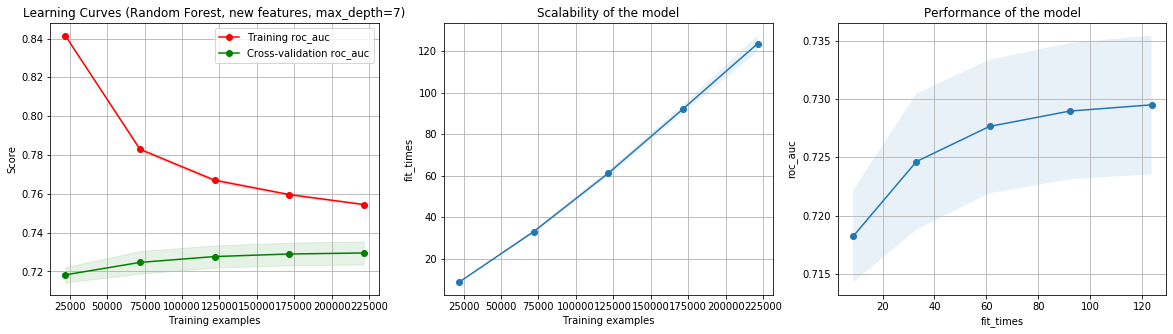

Display Learning Curve - done in 3478s


In [5]:
with hf.timer('Display Learning Curve'):
    title = r"Learning Curves (Random Forest, new features, max_depth=7)"
    hf.display_learning_curve(rf_base_new_fitted, X_train_new, y_train_new, title)
    plt.show()

The random forest model appears to be worse than logistic regression. One reason for this is happenning is because we used one hot encoding which introduced sparsity into our data. Remeber that we have about 120 features at begining, one-hot-encoding gives us 234 features, the extra 110+ features are all binanry dummie variable.

## Feature Hashing

In [17]:
X, y = application_features_new, application_label_new
X_train_fh, X_test_fh, y_train_fh, y_test_fh = train_test_split(X, y, test_size=0.20, random_state=55)

Fitting Randome Forest - done in 254s
Validation ROC: 0.7237855442570483


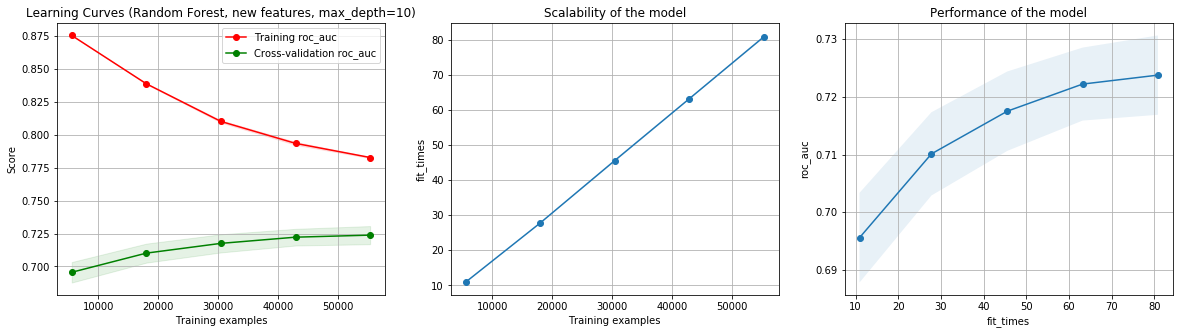

Display Learning Curve - done in 3208s


In [22]:
rf_best = RandomForestClassifier(max_depth=10, n_estimators=8000, min_samples_split=4, 
                                 min_samples_leaf=35, max_leaf_nodes=70, max_samples=0.6, 
                                 class_weight='balanced', random_state=55)
pipe = Pipeline([('hash', HashingEncoder(n_components=220)),
                 ('impute', SimpleImputer(strategy = 'median')), 
                 ('scaler', MinMaxScaler(feature_range = (0, 1))), 
                 ('model', rf_best)])
with hf.timer('Fitting Randome Forest'):
    pipe.fit(X_train_fh, y_train_fh)
    
with hf.timer('Display Learning Curve'):
    title = r"Learning Curves (Random Forest, new features, max_depth=10)"
    hf.display_learning_curve(pipe, X_test_fh, y_test_fh, title)
    plt.show()

## Random Forest Tuning

In [5]:
params_rf = {    
    'n_estimators': [int(x) for x in np.linspace(200, 2000, 10)],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [int(x) for x in np.linspace(3, 8, num=6)],
    'min_samples_split': [int(x) for x in np.linspace(2, 12, num=11)],
    'min_samples_leaf': [int(x) for x in np.linspace(5, 50, num=10)],
    'criterion' :['gini', 'entropy'], 
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample'],
    'max_leaf_nodes': [int(x) for x in np.linspace(30, 100, num=8)],
    'max_samples': [None, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.8]
}

In [6]:
def tune(model, X_train, y_train, params_dict):
    grid = RandomizedSearchCV(estimator=model, param_distributions=params_dict, n_iter=100, 
                          scoring='roc_auc', cv=10, n_jobs=-1, verbose=3)
    print('Imputing missing value...')
    imp = SimpleImputer(strategy = 'median')
    X_train = imp.fit_transform(X_train)
    print('MinMax scaling...')
    sca = MinMaxScaler(feature_range = (0, 1))
    X_train = sca.fit_transform(X_train)
    print('Tuning...')
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    return best_model

In [ ]:
rf_tune = RandomForestClassifier(max_depth=7, n_estimators=300, class_weight='balanced', random_state=55)
with hf.timer('Tuning Random Forest'):
    rf_best = tune(rf_tune, X_train_new, y_train_new, params_rf)

Imputing missing value...
MinMax scaling...
Tuning...
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 22.8min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 162.6min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 366.7min
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed: 667.6min


In [3]:
rf_best = RandomForestClassifier(max_depth=10, n_estimators=700, min_samples_split=4, 
                                 min_samples_leaf=35, max_leaf_nodes=70, max_samples=0.6, 
                                 class_weight='balanced', random_state=55)

In [6]:
with hf.timer('Fitting Tuned Random Forest Model with new features'):
    rf_best_new_fitted = fit(rf_best, 'Random_Forest_New', X_train_new, y_train_new)

Training data shape:  (246009, 234)
Model saved as ['Models/Random_Forest_New.md']
Fitting Tuned Random Forest Model with new features - done in 188s


Validation ROC: 0.7344196789031278


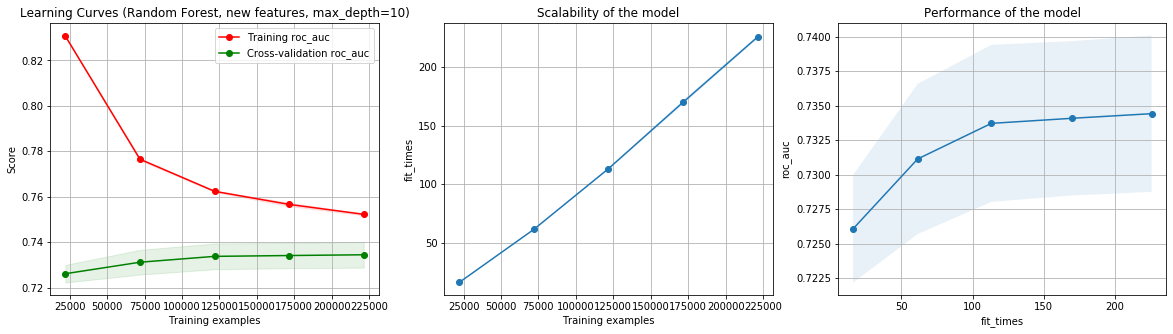

Display Learning Curve - done in 6437s


In [8]:
with hf.timer('Display Learning Curve'):
    title = r"Learning Curves (Random Forest, new features, max_depth=10)"
    hf.display_learning_curve(rf_best_new_fitted, X_train_new, y_train_new, title)
    plt.show()

In [9]:
feat_importance_df = pd.DataFrame()
feat_importance_df["feature"] = feat_names
feat_importance_df["importance"] = rf_best_new_fitted['model'].feature_importances_
feat_importance_df.sort_values('importance', ascending=False, inplace=True)

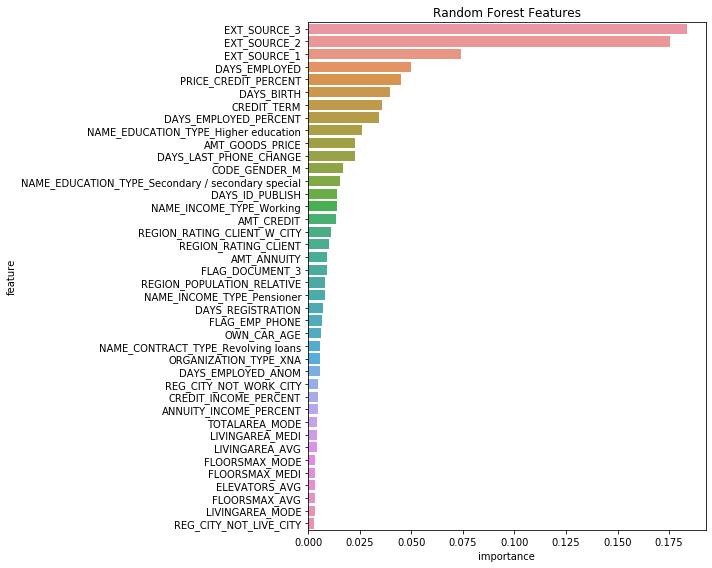

In [14]:
plt.figure(figsize=(10, 8))
sns.barplot(x="importance", y="feature", data=feat_importance_df[:40])
plt.title('Random Forest Features')
plt.tight_layout()
plt.show()

[RandomForestClassifier(class_weight='balanced', max_depth=10, max_leaf_nodes=70,
                       max_samples=0.6, min_samples_leaf=35,
                       min_samples_split=4, n_estimators=700, random_state=55)]

Out-of-Sample Performance:

              precision    recall  f1-score   support

      Repaid      0.959     0.703     0.811     56559
     Default      0.161     0.655     0.259      4943

    accuracy                          0.699     61502
   macro avg      0.560     0.679     0.535     61502
weighted avg      0.895     0.699     0.767     61502

roc_auc: 0.6786284558409189

Confusion Matrix:



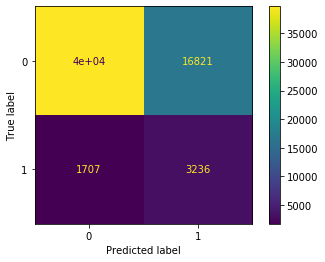

Evaluate Model Performance - done in 7s


In [10]:
with hf.timer('Evaluate Model Performance'):
    hf.evaluate_on_test(rf_best_new_fitted, X_test_new, y_test_new)